## The Battle of Neighborhoods: London

### Clustering schools based on house price and the number of libraries and museums

In [245]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd 
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

import folium

from time import sleep

## 1. Data preparation

### London boroughs

In [2]:
# read the information of London borough from wiki
url='https://en.wikipedia.org/wiki/List_of_London_boroughs'
London_data=pd.read_html(url)

In [3]:
# get the info of 32 Boroughs and the City of London
London_data[:2]

[                            Borough     Inner Status  \
 0     Barking and Dagenham [note 1]       NaN    NaN   
 1                            Barnet       NaN    NaN   
 2                            Bexley       NaN    NaN   
 3                             Brent       NaN    NaN   
 4                           Bromley       NaN    NaN   
 5                            Camden       NaN    NaN   
 6                           Croydon       NaN    NaN   
 7                            Ealing       NaN    NaN   
 8                           Enfield       NaN    NaN   
 9                Greenwich [note 2]  [note 3]  Royal   
 10                          Hackney       NaN    NaN   
 11  Hammersmith and Fulham [note 4]       NaN    NaN   
 12                         Haringey  [note 3]    NaN   
 13                           Harrow       NaN    NaN   
 14                         Havering       NaN    NaN   
 15                       Hillingdon       NaN    NaN   
 16                         Hou

In [4]:
# Convert to dataframe 
Borough=pd.DataFrame(London_data[0])
City_of_London=pd.DataFrame(London_data[1])

# add city of London to Borough for convenience
Greater_London=Borough.append(City_of_London)

# reset index
Greater_London.reset_index(drop=True, inplace=True)

Greater_London.head()

,Borough,Inner,Status,Local authority,Political control,Headquarters,Area (sq mi),Population (2013 est)[1],Co-ordinates,Nr. in map,Population(2011 est),Nr. inmap
0,Barking and Dagenham [note 1],NaN,NaN,Barking and Dagenham London Borough Council,Labour,"Town Hall, 1 Town Square",13.93,194352.0,51°33′39″N 0°09′21″E﻿ / ﻿51.5607°N 0.1557°E,25.0,NaN,NaN
1,Barnet,NaN,NaN,Barnet London Borough Council,Conservative,"North London Business Park, Oakleigh Road South",33.49,369088.0,51°37′31″N 0°09′06″W﻿ / ﻿51.6252°N 0.1517°W,31.0,NaN,NaN
2,Bexley,NaN,NaN,Bexley London Borough Council,Conservative,"Civic Offices, 2 Watling Street",23.38,236687.0,51°27′18″N 0°09′02″E﻿ / ﻿51.4549°N 0.1505°E,23.0,NaN,NaN
3,Brent,NaN,NaN,Brent London Borough Council,Labour,"Brent Civic Centre, Engineers Way",16.70,317264.0,51°33′32″N 0°16′54″W﻿ / ﻿51.5588°N 0.2817°W,12.0,NaN,NaN
4,Bromley,NaN,NaN,Bromley London Borough Council,Conservative,"Civic Centre, Stockwell Close",57.97,317899.0,51°24′14″N 0°01′11″E﻿ / ﻿51.4039°N 0.0198°E,20.0,NaN,NaN


__clean data__

In [9]:
# get the list of boroughs
london_borough=Greater_London[['Borough']]

# edit the names of Borough, delete suffix [note #]
# get borough names with suffix
borough_with_suffix=london_borough['Borough'].str.contains('note')
for i, borough in london_borough[borough_with_suffix].iterrows():
    name_no_suffix=borough['Borough'][:-9]
    london_borough.loc[i,'Borough']=name_no_suffix

london_borough.head()

/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,Borough
0,Barking and Dagenham
1,Barnet
2,Bexley
3,Brent
4,Bromley


In [10]:
# Gathering the Latitude and Longitude coordinates for each borough using geolocater
for i in range(london_borough.shape[0]):
    borough=london_borough.loc[i,'Borough']
    address= borough + ',England'
    geolocator = Nominatim(user_agent="LDN_explorer")
    
    location = geolocator.geocode(address)
    
    latitude = location.latitude
    longitude = location.longitude        
    london_borough.loc[i,'Latitude']=latitude
    london_borough.loc[i,'Longitude']=longitude
    sleep(1)

london_borough.head()

/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,Borough,Latitude,Longitude
0,Barking and Dagenham,51.554117,0.150504
1,Barnet,51.653090,-0.200226
2,Bexley,51.441679,0.150488
3,Brent,51.441635,0.234519
4,Bromley,51.402805,0.014814


In [57]:
# save file
london_borough.to_csv('London_borough_location.csv',index=False)

### House Price by Borough

In [11]:
filename='London-house-prices-borough.csv'

In [12]:
house_price=pd.read_csv(filename)
house_price.head()

,Code,Area,Year,Measure,Value
0,E09000001,City of London,Year ending Dec 1995,Median,"105,000"
1,E09000002,Barking and Dagenham,Year ending Dec 1995,Median,"49,000"
2,E09000003,Barnet,Year ending Dec 1995,Median,"85,125"
3,E09000004,Bexley,Year ending Dec 1995,Median,"62,000"
4,E09000005,Brent,Year ending Dec 1995,Median,"68,000"


In [13]:
house_price.shape

(12015, 5)

In [14]:
house_price.groupby('Measure').count()

,Code,Area,Year,Value
Measure,,,,
Mean,4005,4005,4005,4005
Median,4005,4005,4005,4005
Sales,4005,4005,4005,4005


We will use the Median and Mean house price at the end of each year from 1995 to 2017 for modeling and predicting

In [47]:
# select the year-end data
house_price_dec=house_price.loc[house_price['Year'].str.contains('Dec'),:]
house_price_dec.head()

,Code,Area,Year,Measure,Value
0,E09000001,City of London,Year ending Dec 1995,Median,"105,000"
1,E09000002,Barking and Dagenham,Year ending Dec 1995,Median,"49,000"
2,E09000003,Barnet,Year ending Dec 1995,Median,"85,125"
3,E09000004,Bexley,Year ending Dec 1995,Median,"62,000"
4,E09000005,Brent,Year ending Dec 1995,Median,"68,000"


In [48]:
# set column 'Year' to type int
Year=house_price_dec['Year'].str.split(' ',expand = True)

house_price_dec['YearEnd']=Year[3]

house_price_dec.head()

/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Code,Area,Year,Measure,Value,YearEnd
0,E09000001,City of London,Year ending Dec 1995,Median,"105,000",1995
1,E09000002,Barking and Dagenham,Year ending Dec 1995,Median,"49,000",1995
2,E09000003,Barnet,Year ending Dec 1995,Median,"85,125",1995
3,E09000004,Bexley,Year ending Dec 1995,Median,"62,000",1995
4,E09000005,Brent,Year ending Dec 1995,Median,"68,000",1995


In [49]:
# drop columns
house_price_dec.drop(columns=['Code','Year'],inplace=True)

# rename columns
house_price_dec.rename(columns={'Area':'Borough','Value':'Price'},inplace=True)

house_price_dec=house_price_dec.reset_index(drop=True)

/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [50]:
house_price_dec.head()

,Borough,Measure,Price,YearEnd
0,City of London,Median,"105,000",1995
1,Barking and Dagenham,Median,"49,000",1995
2,Barnet,Median,"85,125",1995
3,Bexley,Median,"62,000",1995
4,Brent,Median,"68,000",1995


In [53]:
# drop rows with borough not in the london_borough dataframe
local_index=[]
for index in range(0,house_price_dec.shape[0]):
    if house_price_dec['Borough'].iloc[index] not in london_borough['Borough'].tolist():
        local_index.append(index)

house_price_dec=house_price_dec.drop(local_index,axis=0)
house_price_dec.reset_index(drop=True, inplace=True)

print(house_price_dec.shape)
house_price_dec.head()

(2277, 4)


,Borough,Measure,Price,YearEnd
0,City of London,Median,"105,000",1995
1,Barking and Dagenham,Median,"49,000",1995
2,Barnet,Median,"85,125",1995
3,Bexley,Median,"62,000",1995
4,Brent,Median,"68,000",1995


In [110]:
# delete comma in Price column
for i in range(0,house_price_dec.shape[0]):
    house_price_dec.loc[i,'Price']=house_price_dec.loc[i,'Price'].replace(',','')
    
house_price_dec.head()

,Borough,Measure,Price,YearEnd
0,City of London,Median,105000,1995
1,Barking and Dagenham,Median,49000,1995
2,Barnet,Median,85125,1995
3,Bexley,Median,62000,1995
4,Brent,Median,68000,1995


In [111]:
# select median and mean value
house_price_median=house_price_dec.loc[house_price_dec['Measure']=='Median',:]
house_price_mean=house_price_dec.loc[house_price_dec['Measure']=='Mean',:].reset_index(drop=True)

In [112]:
house_price_median.head()

,Borough,Measure,Price,YearEnd
0,City of London,Median,105000,1995
1,Barking and Dagenham,Median,49000,1995
2,Barnet,Median,85125,1995
3,Bexley,Median,62000,1995
4,Brent,Median,68000,1995


In [113]:
print(house_price_mean.shape)
house_price_mean.head()

(759, 4)


,Borough,Measure,Price,YearEnd
0,City of London,Mean,146043,1995
1,Barking and Dagenham,Mean,50615,1995
2,Barnet,Mean,111019,1995
3,Bexley,Mean,66294,1995
4,Brent,Mean,77258,1995


In [114]:
# save file
house_price_median.to_csv('London_MedianHousePrice_borough_1995_2017.csv',index=False)
house_price_mean.to_csv('London_MeanHousePrice_borough_1995_2017.csv',index=False)


### Schools Atlas

In [22]:
file_school='all_schools.csv'
school=pd.read_csv(file_school)

In [23]:
school.head()

,OBJECTID,URN,SCHOOL_NAM,TYPE,PHASE,ADDRESS,TOWN,POSTCODE,STATUS,GENDER,...,LA_NAME,WEBLINK,AGE,map_icon,NEW_URN,OLD_URN,map_icon_l,Primary,x,y
0,1,135155,Ayesha Siddiqa Girls School,Other Independent School,Not applicable,165-169 The Broadway,Southall,UB1 1LR,Open,Girls,...,Ealing,,19-Nov,,,,2,0,-0.378496,51.507500
1,2,140492,Beis Medrash Elyon,Other Independent School,Not applicable,233 West Hendon Broadway,London,NW9 7DG,Open,Boys,...,Barnet,,16-Nov,,,,2,0,-0.241628,51.578999
2,3,141411,Big Creative Independent School,Other Independent School,Not applicable,Silver Birch House,Walthamstow,E17 5SD,Open,Mixed,...,Waltham Forest,,15 - 16,,,,2,0,-0.042590,51.594002
3,4,142336,Wetherby Senior School,Other Independent School,Not applicable,100 Marylebone Lane,London,W1U 2QB,Open,Boys,...,Westminster,,16-Nov,,,,2,0,-0.150409,51.517601
4,5,100042,St Mary's Kilburn Church of England Primary Sc...,Voluntary Aided School,Primary,Quex Road,London,NW6 4PG,Open,Mixed,...,Camden,http://www.stmarykilburn.camden.sch.uk/,11-Mar,VOLUNTARY,,,2,1,-0.193367,51.540402


In [24]:
# select name, addresses, boroughs, towns, postcodes and location coordinates as school_data
school_data=school[['SCHOOL_NAM', 'ADDRESS', 'TOWN', 'LA_NAME','POSTCODE']]

school_data['Latitude']=school[['y']]
school_data['Longitude']=school[['x']]

print(school_data.shape)
school_data.head()



(3889, 7)


/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/wangyifei/opt/anaconda3/envs/Cousera_learning/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,SCHOOL_NAM,ADDRESS,TOWN,LA_NAME,POSTCODE,Latitude,Longitude
0,Ayesha Siddiqa Girls School,165-169 The Broadway,Southall,Ealing,UB1 1LR,51.507500,-0.378496
1,Beis Medrash Elyon,233 West Hendon Broadway,London,Barnet,NW9 7DG,51.578999,-0.241628
2,Big Creative Independent School,Silver Birch House,Walthamstow,Waltham Forest,E17 5SD,51.594002,-0.042590
3,Wetherby Senior School,100 Marylebone Lane,London,Westminster,W1U 2QB,51.517601,-0.150409
4,St Mary's Kilburn Church of England Primary Sc...,Quex Road,London,Camden,NW6 4PG,51.540402,-0.193367


In [28]:
# drop rows with boroughs that are not in the london_borough dataframe
local_index = []
for index in range(0,school_data.shape[0]):
    if school_data['LA_NAME'].iloc[index] not in london_borough['Borough'].tolist():
        local_index.append(index)

school_data=school_data.drop(local_index, axis=0)
school_data.reset_index(drop=True, inplace=True)

print(school_data.shape)
school_data.head()


(3372, 7)


,SCHOOL_NAM,ADDRESS,TOWN,LA_NAME,POSTCODE,Latitude,Longitude
0,Ayesha Siddiqa Girls School,165-169 The Broadway,Southall,Ealing,UB1 1LR,51.507500,-0.378496
1,Beis Medrash Elyon,233 West Hendon Broadway,London,Barnet,NW9 7DG,51.578999,-0.241628
2,Big Creative Independent School,Silver Birch House,Walthamstow,Waltham Forest,E17 5SD,51.594002,-0.042590
3,Wetherby Senior School,100 Marylebone Lane,London,Westminster,W1U 2QB,51.517601,-0.150409
4,St Mary's Kilburn Church of England Primary Sc...,Quex Road,London,Camden,NW6 4PG,51.540402,-0.193367


In [59]:
# save file
school_data.to_csv('London_school_location.csv',index=False)


## 2. Analysis of Data

In [115]:
london_location=pd.read_csv('London_borough_location.csv')

london_school=pd.read_csv('London_school_location.csv')

mean_house_price=pd.read_csv('London_MeanHousePrice_borough_1995_2017.csv')
median_house_price=pd.read_csv('London_MedianHousePrice_borough_1995_2017.csv')

print('Data loaded successfully!')

Data loaded successfully!


In [116]:
london_location.head()

,Borough,Latitude,Longitude
0,Barking and Dagenham,51.554117,0.150504
1,Barnet,51.653090,-0.200226
2,Bexley,51.441679,0.150488
3,Brent,51.441635,0.234519
4,Bromley,51.402805,0.014814


In [117]:
london_school.head()

,SCHOOL_NAM,ADDRESS,TOWN,LA_NAME,POSTCODE,Latitude,Longitude
0,Ayesha Siddiqa Girls School,165-169 The Broadway,Southall,Ealing,UB1 1LR,51.507500,-0.378496
1,Beis Medrash Elyon,233 West Hendon Broadway,London,Barnet,NW9 7DG,51.578999,-0.241628
2,Big Creative Independent School,Silver Birch House,Walthamstow,Waltham Forest,E17 5SD,51.594002,-0.042590
3,Wetherby Senior School,100 Marylebone Lane,London,Westminster,W1U 2QB,51.517601,-0.150409
4,St Mary's Kilburn Church of England Primary Sc...,Quex Road,London,Camden,NW6 4PG,51.540402,-0.193367


In [118]:
mean_house_price.drop('Measure',axis=1,inplace=True)
mean_house_price.head()

,Borough,Price,YearEnd
0,City of London,146043,1995
1,Barking and Dagenham,50615,1995
2,Barnet,111019,1995
3,Bexley,66294,1995
4,Brent,77258,1995


In [119]:
median_house_price.drop('Measure',axis=1,inplace=True)
median_house_price.head()

,Borough,Price,YearEnd
0,City of London,105000,1995
1,Barking and Dagenham,49000,1995
2,Barnet,85125,1995
3,Bexley,62000,1995
4,Brent,68000,1995


### Creat map of London boroughs

In [62]:
address = 'London, England'

geolocator = Nominatim(user_agent='LDN_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geographical coordinate of London are {}, {}.'.format(latitude, longitude))

The geographical coordinate of London are 51.5073219, -0.1276474.


In [67]:
# Creating a map using latitude and longitude values
london_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough in zip(london_location['Latitude'], london_location['Longitude'], london_location['Borough']):
    label = '{}'.format(borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(london_map)  

london_map

### Creat map of schools

In [71]:
# Using 25% data as samples to create map
school_sample=london_school.sample(n=london_school.shape[0]//4)

In [72]:
# Creating a map using latitude and longitude values
school_map = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, school, town in zip(school_sample['Latitude'], school_sample['Longitude'], school_sample['SCHOOL_NAM'], school_sample['LA_NAME']):
    label = '{}, {}'.format(school, town)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='orange',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(school_map)  

school_map

### Exploration of house price data

In [121]:
# merge mean and median house prices
london_house_price=mean_house_price.set_index(['Borough','YearEnd']).join(median_house_price.set_index(['Borough','YearEnd']),
                                                                          lsuffix='_mean',rsuffix='_median'
                                                                         ).reset_index()


london_house_price.head()

,Borough,YearEnd,Price_mean,Price_median
0,City of London,1995,146043,105000
1,Barking and Dagenham,1995,50615,49000
2,Barnet,1995,111019,85125
3,Bexley,1995,66294,62000
4,Brent,1995,77258,68000


In [122]:
# creat a dictionary of house prices with Boroughs as keys
borough_list=london_location['Borough'].tolist()
house_price_collection={}

for index in range(0,london_location.shape[0]):
    house_price_collection[london_location['Borough'].iloc[index]] = london_house_price[london_house_price['Borough']==london_location['Borough'].iloc[index]].reset_index(drop=True)

# house_price_collection

__Use the linear model to predict the mean and median house prices in 2022__

In [144]:
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

regr_mean = linear_model.LinearRegression()
regr_median = linear_model.LinearRegression()

house_price_2022 = pd.DataFrame(columns=['Borough','2022 Mean Price','R2_mean','2022 Median Price','R2_median'])

In [149]:
i=0
for borough in borough_list:
    X=np.asanyarray(house_price_collection[borough][['YearEnd']])
    y_mean=np.asanyarray(house_price_collection[borough][['Price_mean']])
    y_median=np.asanyarray(house_price_collection[borough][['Price_median']])
    
    # fill in borough names
    house_price_2022.loc[i,'Borough']=borough

    # train the model for mean prices
    X_mean_train, X_mean_test, y_mean_train, y_mean_test = train_test_split(X, y_mean, test_size=0.2, random_state=4)
    regr_mean.fit(X_mean_train,y_mean_train)
    y_mean_predict=regr_mean.predict(X_mean_test)
    y_mean_2022=regr_mean.predict([[2022]])
    
    house_price_2022.loc[i,['2022 Mean Price','R2_mean']] = [y_mean_2022[0][0], r2_score(y_mean_predict,y_mean_test)]
    
    # train the model for median prices
    X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X, y_median, test_size=0.2, random_state=4)
    regr_median.fit(X_median_train,y_median_train)
    y_median_predict=regr_median.predict(X_median_test)
    y_median_2022=regr_median.predict([[2022]])
    
    house_price_2022.loc[i,['2022 Median Price','R2_median']] = [y_median_2022[0][0], r2_score(y_median_predict,y_median_test)]
     
        
    i=i+1

    
print('Minium r2 score of mean prices: {}'.format(min(r2_score_by_borough['R2_mean'])),'\n'
      'Minium r2 score of median prices: {}'.format(min(r2_score_by_borough['R2_median']))
     )
                                                   
      
house_price_2022.head()


Minium r2 score of mean prices: 0.8609998544288037 
Minium r2 score of median prices: 0.8640783085565458


,Borough,2022 Mean Price,R2_mean,2022 Median Price,R2_median
0,Barking and Dagenham,306829,0.920082,299937,0.899747
1,Barnet,720990,0.993919,541241,0.972209
2,Bexley,369800,0.951327,351463,0.939776
3,Brent,629874,0.987437,522300,0.98512
4,Bromley,536411,0.964317,454591,0.95137


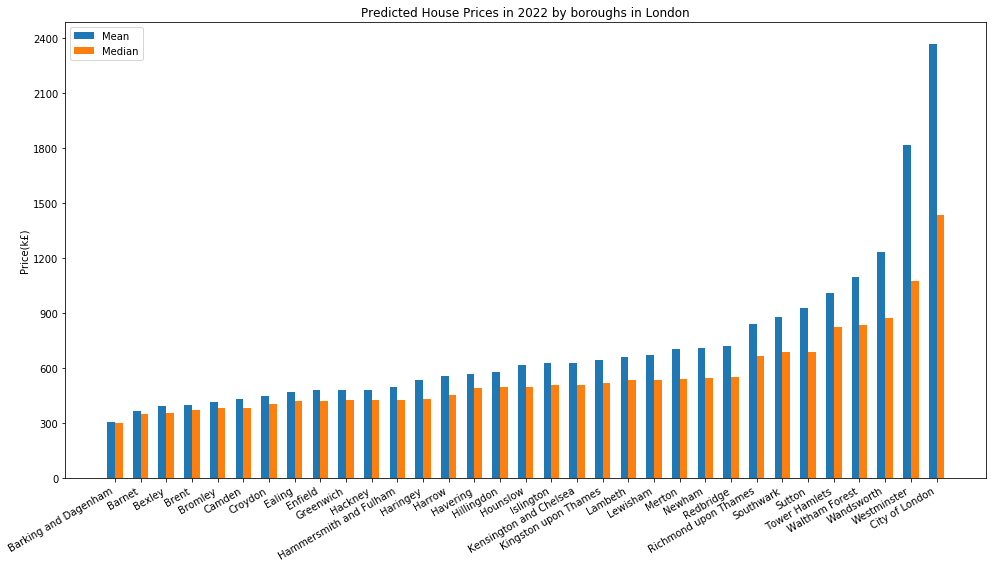

In [205]:
# plot the predicted price in bar chart
x=np.arange(0,house_price_2022.shape[0])
width=0.3

fig,ax=plt.subplots(figsize=(14,8))
ax0=ax.bar(x-width/2,(house_price_2022['2022 Mean Price'].sort_values())/1000,width,label='Mean',align='center')
ax1=ax.bar(x+width/2,(house_price_2022['2022 Median Price'].sort_values())/1000,width,label='Median',align='center')

ax.set_yticks(np.arange(0,2500,step=300))

ax.set_ylabel('Price(k£)')
ax.set_title('Predicted House Prices in 2022 by boroughs in London')
ax.set_xticks(x)
ax.set_xticklabels(house_price_2022['Borough'],rotation=30,horizontalalignment='right')
ax.legend()

# ax.hlines(y=600, xmin=-1, xmax=house_price_2022.shape[0],linestyle='dashed')

fig.tight_layout()
plt.savefig('Predicted_House_Prices(2020).png')

plt.show()


__Aggregate House prices data with schools__

In [219]:
school_house_prices=pd.DataFrame(columns=['School','Address','Borough','Post Code',
                                          'Mean House Prices','Median House Prices',
                                          'Library','Museum'])
school_house_prices['School']=london_school['SCHOOL_NAM']
school_house_prices['Address'] = london_school['ADDRESS']
school_house_prices['Borough'] = london_school['LA_NAME']
school_house_prices['Post Code'] = london_school['POSTCODE']
school_house_prices['Latitude'] = london_school['Latitude']
school_house_prices['Longitude'] = london_school['Longitude']

for i in range(0,school_house_prices.shape[0]):
    borough_index=house_price_2022.loc[house_price_2022['Borough']==school_house_prices['Borough'].iloc[i]]
    if (borough_index.index.size != 0):
        school_house_prices.loc[i,'Mean House Prices']=house_price_2022['2022 Mean Price'].iloc[borough_index.index[0]]
        school_house_prices.loc[i,'Median House Prices']=house_price_2022['2022 Median Price'].iloc[borough_index.index[0]]

school_house_prices.head()

,School,Address,Borough,Post Code,Mean House Prices,Median House Prices,Library,Museum,Latitude,Longitude
0,Ayesha Siddiqa Girls School,165-169 The Broadway,Ealing,UB1 1LR,629923,500665,NaN,NaN,51.507500,-0.378496
1,Beis Medrash Elyon,233 West Hendon Broadway,Barnet,NW9 7DG,720990,541241,NaN,NaN,51.578999,-0.241628
2,Big Creative Independent School,Silver Birch House,Waltham Forest,E17 5SD,449010,433996,NaN,NaN,51.594002,-0.042590
3,Wetherby Senior School,100 Marylebone Lane,Westminster,W1U 2QB,1.81882e+06,1.0782e+06,NaN,NaN,51.517601,-0.150409
4,St Mary's Kilburn Church of England Primary Sc...,Quex Road,Camden,NW6 4PG,1.23526e+06,833739,NaN,NaN,51.540402,-0.193367


__Use the FourSquare API to find the number of libraries and museums within 1 km__

In [217]:
CLIENT_ID = 'NOZCAKKTFOW5522IJQWIBBX5TDMTZ2DKP5N3QLKGTSAX15UY' # your Foursquare ID
CLIENT_SECRET = 'NEQY2K4KHTHRGLBBBJPI3RVH515EPERFVS0XASIHJEY4O4WJ' # your Foursquare Secret
VERSION = '20180604'


In [327]:
radius = 1000
LIMIT = 250

search_ind=['Library','Museum']
for query in search_ind:
    search_query=query
    
    for i in range(0,school_house_prices.shape[0]):

        latitude=school_house_prices['Latitude'].loc[i]
        longitude=school_house_prices['Longitude'].loc[i]

        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
        results = requests.get(url).json()
        if 'venues' in results['response']:
            venues = results['response']['venues']
            dataframe = json_normalize(venues)
            school_house_prices.loc[i,query] = dataframe.shape[0]
        else:
            school_house_prices.loc[i,query] = 0
        
# school_house_prices = school_house_prices.dropna()
school_house_prices.reset_index(drop=True)

school_house_prices.head()
    
    

,School,Address,Borough,Post Code,Mean House Prices,Median House Prices,Library,Museum,Latitude,Longitude,Cluster Labels
0,Ayesha Siddiqa Girls School,165-169 The Broadway,Ealing,UB1 1LR,629923,500665,1,0,51.507500,-0.378496,0
1,Beis Medrash Elyon,233 West Hendon Broadway,Barnet,NW9 7DG,720990,541240,1,0,51.578999,-0.241628,0
2,Big Creative Independent School,Silver Birch House,Waltham Forest,E17 5SD,449010,433996,0,0,51.594002,-0.042590,2
3,Wetherby Senior School,100 Marylebone Lane,Westminster,W1U 2QB,1818817,1078201,30,9,51.517601,-0.150409,1
4,St Mary's Kilburn Church of England Primary Sc...,Quex Road,Camden,NW6 4PG,1235263,833739,3,0,51.540402,-0.193367,3


In [328]:
school_house_prices['Mean House Prices']=school_house_prices['Mean House Prices'].astype(int)
school_house_prices['Median House Prices']=school_house_prices['Median House Prices'].astype(int)

school_house_prices['Library']=school_house_prices['Library'].astype(int)
school_house_prices['Museum']=school_house_prices['Museum'].astype(int)

In [329]:
school_house_prices.dtypes

School                  object
Address                 object
Borough                 object
Post Code               object
Mean House Prices        int64
Median House Prices      int64
Library                  int64
Museum                   int64
Latitude               float64
Longitude              float64
Cluster Labels           int32
dtype: object

In [330]:
school_house_prices.drop_duplicates(keep = 'first', inplace = True)

In [331]:
school_house_prices.reset_index(drop=True,inplace=True)

In [332]:
max(school_house_prices['Library'])

50

In [333]:
# save file
school_house_prices.to_csv('London_Schools_HousePrices2022_LibMuseum')

### 3. Clustering

### Clustering the schools based on the house prices and number of libraries and museums

In [334]:
from sklearn.cluster import KMeans

In [335]:
kclusters=4

school_grouped_clustering=school_house_prices[['Mean House Prices','Median House Prices',
                                              'Library','Museum',
                                              'Latitude','Longitude']]
kmeans=KMeans(n_clusters=kclusters,random_state=0).fit(school_grouped_clustering)

kmeans.labels_[0:10]


array([0, 0, 3, 1, 2, 0, 0, 0, 0, 1], dtype=int32)

In [336]:
school_house_prices['Cluster Labels']=kmeans.labels_
school_house_prices.head()

,School,Address,Borough,Post Code,Mean House Prices,Median House Prices,Library,Museum,Latitude,Longitude,Cluster Labels
0,Ayesha Siddiqa Girls School,165-169 The Broadway,Ealing,UB1 1LR,629923,500665,1,0,51.507500,-0.378496,0
1,Beis Medrash Elyon,233 West Hendon Broadway,Barnet,NW9 7DG,720990,541240,1,0,51.578999,-0.241628,0
2,Big Creative Independent School,Silver Birch House,Waltham Forest,E17 5SD,449010,433996,0,0,51.594002,-0.042590,3
3,Wetherby Senior School,100 Marylebone Lane,Westminster,W1U 2QB,1818817,1078201,30,9,51.517601,-0.150409,1
4,St Mary's Kilburn Church of England Primary Sc...,Quex Road,Camden,NW6 4PG,1235263,833739,3,0,51.540402,-0.193367,2


In [337]:
# plot a third of schools as samples
school_sample = school_house_prices.sample(n=london_school.shape[0]//3)

# creat map of London
address = 'London, England'
geolocator = Nominatim(user_agent='LDN_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers
markers_colors = []
for lat, lon, poi, price, cluster in zip(school_sample['Latitude'], school_sample['Longitude'], school_sample['School'], school_sample['Median House Prices'], school_sample['Cluster Labels']):
    label = folium.Popup(str(poi) + ', '+ str('%.2f' % (price/1000)) + 'k,'+' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)


map_clusters

__Cluster 0__

In [338]:
print('Average median house prices for Cluster 0 (RED) is', school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Median House Prices'].mean())

Highest = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Median House Prices'])
Highest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Median House Prices']).argmax()

Most_lib = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Library'])
Most_lib_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Library']).argmax()

Most_mus = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Museum'])
Most_mus_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Museum']).argmax()



Lowest=min(school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Median House Prices'])
Lowest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 0]['Median House Prices']).argmin()


print('School with highest median house prices in Cluster 0 is', school_house_prices.loc[Highest_index,'School'], 
      'with a median house prices of', Highest)
print('School with lowest median house prices in Cluster 0 is', school_house_prices.loc[Lowest_index,'School'], 
      'with a median house prices of', Lowest)
print('School close to most libraries in Cluster 0 is', school_house_prices.loc[Most_lib_index,'School'], 
      'with a number of libraries of', Most_lib)
print('School close to most Museums in Cluster 0 is', school_house_prices.loc[Most_mus_index,'School'], 
      'with a number of Museums of', Most_mus)
print('There are',school_house_prices.loc[school_house_prices['Cluster Labels'] == 0].shape[0], 'schools in cluster 0 in total' )

school_house_prices.loc[school_house_prices['Cluster Labels'] == 0].head()
      


Average median house prices for Cluster 0 (RED) is 525295.4032846715
School with highest median house prices in Cluster 0 is Big Creative Independent School with a median house prices of 554687
School with lowest median house prices in Cluster 0 is North Bridge Nursery School with a median house prices of 491768
School close to most libraries in Cluster 0 is Dulwich Prep London with a number of libraries of 27
School close to most Museums in Cluster 0 is Thomas's Fulham with a number of Museums of 20
There are 1096 schools in cluster 0 in total


,School,Address,Borough,Post Code,Mean House Prices,Median House Prices,Library,Museum,Latitude,Longitude,Cluster Labels
0,Ayesha Siddiqa Girls School,165-169 The Broadway,Ealing,UB1 1LR,629923,500665,1,0,51.507500,-0.378496,0
1,Beis Medrash Elyon,233 West Hendon Broadway,Barnet,NW9 7DG,720990,541240,1,0,51.578999,-0.241628,0
5,De Beauvoir Primary School,80 Tottenham Road,Hackney,N1 4BS,644989,554687,4,1,51.545299,-0.077000,0
6,Queensbridge Primary School,Queensbridge Road,Hackney,E8 3ND,644989,554687,4,1,51.539299,-0.071761,0
7,Princess May Primary School,Princess May Road,Hackney,N16 8AJ,644989,554687,6,1,51.552799,-0.077609,0


__Cluster 1__

In [339]:
print('Average median house prices for Cluster 1 (PURPLE) is', school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Median House Prices'].mean())

Highest = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Median House Prices'])
Highest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Median House Prices']).argmax()

Most_lib = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Library'])
Most_lib_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Library']).argmax()

Most_mus = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Museum'])
Most_mus_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Museum']).argmax()

Lowest=min(school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Median House Prices'])
Lowest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 1]['Median House Prices']).argmin()


print('School with highest median house prices in Cluster 1 is', school_house_prices.loc[Highest_index,'School'], 
      'with a median house prices of', Highest)

print('School with lowest median house prices in Cluster 1 is', school_house_prices.loc[Lowest_index,'School'], 
      'with a median house prices of', Lowest)

print('School close to most libraries in Cluster 1 is', school_house_prices.loc[Most_lib_index,'School'], 
      'with a number of libraries of', Most_lib)
print('School close to most Museums in Cluster 1 is', school_house_prices.loc[Most_mus_index,'School'], 
      'with a number of Museums of', Most_mus)
print('There are',school_house_prices.loc[school_house_prices['Cluster Labels'] == 1].shape[0], 'schools in cluster 1 in total' )

school_house_prices.loc[school_house_prices['Cluster Labels'] == 1].head()
   

Average median house prices for Cluster 1 (PURPLE) is 1253979.8363636364
School with highest median house prices in Cluster 1 is Beis Medrash Elyon with a median house prices of 1436269
School with lowest median house prices in Cluster 1 is Ayesha Siddiqa Girls School with a median house prices of 1078201
School close to most libraries in Cluster 1 is The Hall School with a number of libraries of 50
School close to most Museums in Cluster 1 is Colfes School with a number of Museums of 50
There are 165 schools in cluster 1 in total


,School,Address,Borough,Post Code,Mean House Prices,Median House Prices,Library,Museum,Latitude,Longitude,Cluster Labels
3,Wetherby Senior School,100 Marylebone Lane,Westminster,W1U 2QB,1818817,1078201,30,9,51.517601,-0.150409,1
9,Marlborough Primary School,Draycott Avenue,Kensington and Chelsea,SW3 3AP,2366318,1436269,14,43,51.492699,-0.166066,1
79,Redcliffe School,47 Redcliffe Gardens,Kensington and Chelsea,SW10 9JH,2366318,1436269,10,20,51.486198,-0.186566,1
80,Glendower Preparatory School,86/87 Queen's Gate,Kensington and Chelsea,SW7 5JX,2366318,1436269,19,42,51.494000,-0.179168,1
82,Norland Place School,162-166 Holland Park Avenue,Kensington and Chelsea,W11 4UH,2366318,1436269,11,7,51.506199,-0.211695,1


__Cluster 2__

In [340]:
print('Average median house prices for Cluster 2 (BLUE) is', school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Median House Prices'].mean())

Highest = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Median House Prices'])
Highest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Median House Prices']).argmax()


Most_lib = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Library'])
Most_lib_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Library']).argmax()

Most_mus = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Museum'])
Most_mus_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Museum']).argmax()

Lowest=min(school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Median House Prices'])
Lowest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 2]['Median House Prices']).argmin()


print('School with highest median house prices in Cluster 2 is', school_house_prices.loc[Highest_index,'School'], 
      'with a median house prices of', Highest)
print('School with lowest median house prices in Cluster 2 is', school_house_prices.loc[Lowest_index,'School'], 
      'with a median house prices of', Lowest)
print('School close to most libraries in Cluster 2 is', school_house_prices.loc[Most_lib_index,'School'], 
      'with a number of libraries of', Most_lib)
print('School close to most Museums in Cluster 2 is', school_house_prices.loc[Most_mus_index,'School'], 
      'with a number of Museums of', Most_mus)
print('There are',school_house_prices.loc[school_house_prices['Cluster Labels'] == 2].shape[0], 'schools in cluster 2 in total' )

school_house_prices.loc[school_house_prices['Cluster Labels'] == 2].head()
   

Average median house prices for Cluster 2 (BLUE) is 744354.4746543779
School with highest median house prices in Cluster 2 is Big Creative Independent School with a median house prices of 875176
School with lowest median house prices in Cluster 2 is Broadhurst School with a median house prices of 668590
School close to most libraries in Cluster 2 is St Dunstan's College with a number of libraries of 50
School close to most Museums in Cluster 2 is St Dunstan's College with a number of Museums of 50
There are 434 schools in cluster 2 in total


,School,Address,Borough,Post Code,Mean House Prices,Median House Prices,Library,Museum,Latitude,Longitude,Cluster Labels
4,St Mary's Kilburn Church of England Primary Sc...,Quex Road,Camden,NW6 4PG,1235263,833739,3,0,51.540402,-0.193367,2
16,Rutherford House School,217 Balham High Road,Wandsworth,SW17 7BQ,878934,688875,1,1,51.439098,-0.155295,2
19,City of London School for Girls,St Giles' Terrace,City of London,EC2Y 8BB,1012535,875176,32,16,51.519199,-0.094578,2
20,St Paul's Cathedral School,2 New Change,City of London,EC4M 9AD,1012535,875176,20,21,51.513802,-0.096832,2
21,City of London School,Queen Victoria Street,City of London,EC4V 3AL,1012535,875176,28,20,51.511101,-0.099525,2


__Cluster 3__

In [341]:
print('Average median house prices for Cluster 3 (GREEN) is', school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Median House Prices'].mean())

Highest = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Median House Prices'])
Highest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Median House Prices']).argmax()


Most_lib = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Library'])
Most_lib_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Library']).argmax()

Most_mus = max(school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Museum'])
Most_mus_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Museum']).argmax()

Lowest=min(school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Median House Prices'])
Lowest_index = (school_house_prices.loc[school_house_prices['Cluster Labels'] == 3]['Median House Prices']).argmin()


print('School with highest median house prices in Cluster 3 is', school_house_prices.loc[Highest_index,'School'], 
      'with a median house prices of', Highest)
print('School with lowest median house prices in Cluster 3 is', school_house_prices.loc[Lowest_index,'School'], 
      'with a median house prices of', Lowest)
print('School close to most libraries in Cluster 3 is', school_house_prices.loc[Most_lib_index,'School'], 
      'with a number of libraries of', Most_lib)
print('School close to most museums in Cluster 3 is', school_house_prices.loc[Most_mus_index,'School'], 
      'with a number of museums of', Most_mus)
print('There are',school_house_prices.loc[school_house_prices['Cluster Labels'] == 3].shape[0], 'schools in cluster 3 in total' )
school_house_prices.loc[school_house_prices['Cluster Labels'] == 3].head()
   

Average median house prices for Cluster 3 (GREEN) is 401690.31811377243
School with highest median house prices in Cluster 3 is St Paul's Cathedral School with a median house prices of 454590
School with lowest median house prices in Cluster 3 is Beis Medrash Elyon with a median house prices of 299936
School close to most libraries in Cluster 3 is Townsend Primary School with a number of libraries of 8
School close to most museums in Cluster 3 is Virgo Fidelis Preparatory School with a number of museums of 6
There are 1336 schools in cluster 3 in total


,School,Address,Borough,Post Code,Mean House Prices,Median House Prices,Library,Museum,Latitude,Longitude,Cluster Labels
2,Big Creative Independent School,Silver Birch House,Waltham Forest,E17 5SD,449010,433996,0,0,51.594002,-0.042590,3
10,Rush Green Primary School,Dagenham Road,Barking and Dagenham,RM7 0TL,306829,299936,1,0,51.563099,0.176705,3
12,Elm Park Primary School,Southend Road,Havering,RM12 5BG,400991,359134,1,0,51.549702,0.203542,3
13,Davies Lane Primary School,Davies Lane,Waltham Forest,E11 3DR,449010,433996,1,0,51.564499,0.011864,3
15,Rivers Academy West London,Tachbrook Road,Hounslow,TW14 9PD,571089,422911,1,0,51.452900,-0.420888,3
